In [68]:
import numpy as np
import matplotlib.ticker as ticker
import polars as pl
from matplotlib import pyplot as plt
import math
from tqdm import tqdm
import glob
import pyarrow as pa
import pyarrow.parquet as pq

plt.style.use("dark_background")

In [69]:
def plot_df(df_path, type = "csv"):
    df = pl.read_csv(df_path) if type == "csv" else pl.read_parquet(f"{df_path[0]}")
    q = (df.groupby("frame").agg(
                    [
                            (pl.col("fox") == 1).sum().alias("fox"),
                            (pl.col("fox") == 0).sum().alias("rabbit")

                    ]).sort("frame"))
    fig, ax = plt.subplots(2,figsize=(10,13))
    
    ax[0].set_title(df_path)
    
    fl = q["fox"].to_list()
    rl = q["rabbit"].to_list()
    
    ax[0].plot(fl)
    ax[0].plot(rl)
    ax[0].legend(["foxes","rabbits","average"])
    ax[0].set_ylabel("Number of Individuals")
    ax[0].set_xlabel("Frames")
    ax[0].set_yscale("log")
    ax[0].xaxis.set_major_formatter(ticker.EngFormatter())
    
    ax[1].scatter(fl,rl,s=1)
    ax[1].set_ylabel("Rabbits")
    ax[1].set_xlabel("Foxes")
    ax[1].set_xscale("log")
    ax[1].set_yscale("log")

    
    
    

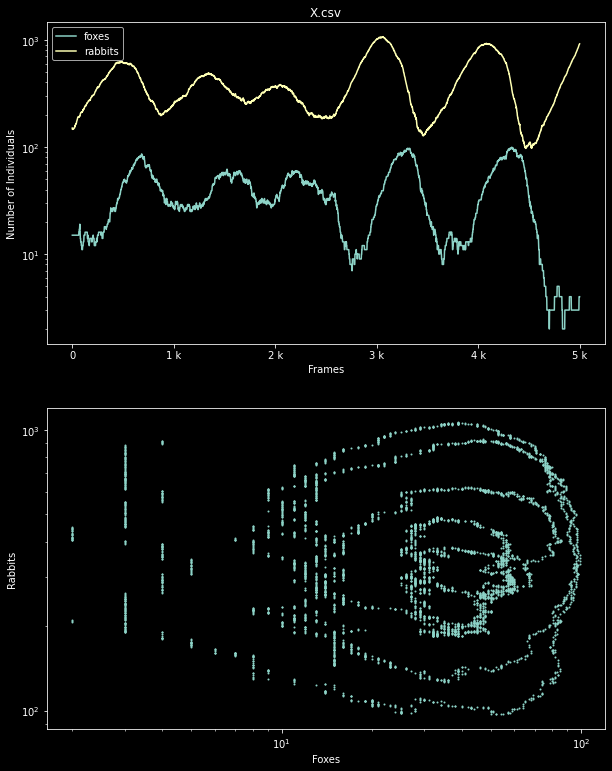

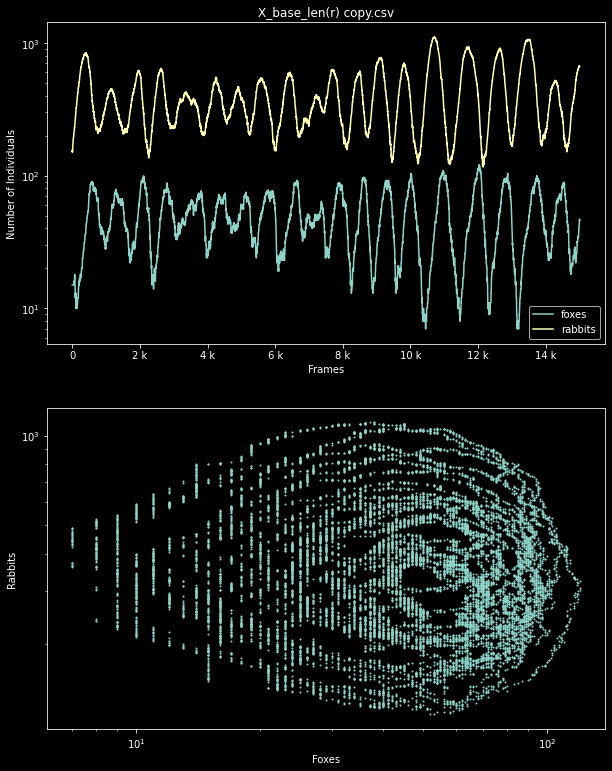

In [72]:
dfs = glob.glob("*.csv")
for df in dfs:
    plot_df(df,"csv")

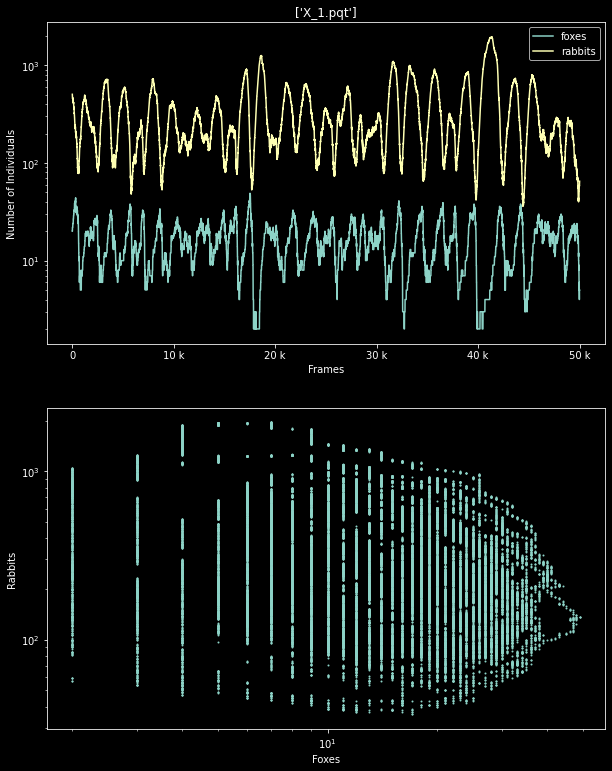

In [71]:
pqt = glob.glob("*.pqt")
for pq in pqt:
    plot_df(pqt,"pqt")